# THE TPU POWER
As we all know that **TPUs** enhance the computation power and also results in good performance of the model. Hence in this notebook we would be going to look up at using the power of TPUs to perform motion prediction on the Lyft Dataset. Specifically we would be training a model using Pytorch on TPU(XLA).

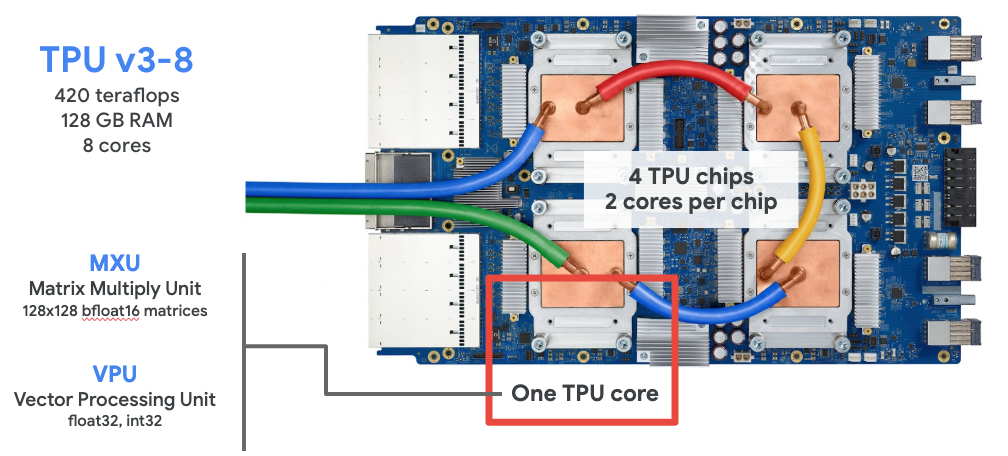
   >Image source: kaggle
   
If we trained the same model six months back we could have had issues in running a Pytorch model on TPU as is evident from this [discussion thread](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/138265).  But now things are pretty much sorted and we can train a model with minimal issues.😍😉

One more thing to praise TPUs is that they are highly memory efficient. They are well designed to reuse memory space and does not store garbage data. Try it on model running with and without TPU and see the results. Share them also.😉

**Following are a set of main parameters and configrations that I would be going to use in this version of the notebook-**

1. Model family: EfficientNet (other architectures such as resnet or inception could also prove beneficial).
2. Pixel size: 0.45
3. Raster Size: 222
4. Training batch size: 12
5. Validation batch size: 8
6. Epochs: 3 (should be atleast 5 or the subset of dataset must be larger)
7. Train Subset length: 5000
8. Validation Subset length: 300

For more information on why I chose this specific combination of `pixel_size` and `raster_size`, please have a look at this [discussion thread](https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/discussion/178323) and this [notebook](https://www.kaggle.com/forwet/lyft-efficientnet-model-train).

<body>
    <p style="color:#f21616;"> Caution: Run the first three cells in the sequential order or you will end up getting errors in imports.</p>
</body>

# Setup Pytorch for TPU.

<body>
<p style="color:#260000"><b>Basically Pytorch uses <a href="https://pytorch.org/xla/release/1.6/index.html">torch_xla</a> package to connect to do computations on TPU. Not only we can train on a single TPU core but we can also perform computations utilizing all the available TPU cores. The following cell loads the torch_xla package and setup dependencies for it.</b></p>
    <p style="color:#de7171"><b>The next cell is inspired from the <a href="https://www.kaggle.com/abhishek/bert-multi-lingual-tpu-training">notebook</a> of one of my favorite mentors- Abhishek Thakur.</b></p>
    </body>

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

<body>
    <p style="color:magenta; font-size:20px; font-family:sanserif;">Imports</p>
</body>

In [ ]:
# Declaring the path to load efficientNet models.
import sys
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master')

In [ ]:
#IMPORTS
import os
import gc
import time
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm
from typing import Dict
import matplotlib.pyplot as plt
from tempfile import gettempdir
from prettytable import PrettyTable
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule

# TORCH
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

# TORCH XLA
import torch_xla
import torch_xla.debug.metrics as met
import torch_xla.distributed.data_parallel as dp
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.test.test_utils as test_utils

# L5Kit
from l5kit.configs import load_config_data
from l5kit.geometry import transform_points
from l5kit.rasterization import build_rasterizer
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset

# EfficientNet
from efficientnet_pytorch import model as enet

# Catalyst Module
from catalyst import dl
from catalyst.utils import metrics
from catalyst.dl import utils
from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Configurations

In [ ]:
# CONFIGRATIONS

class Config:
    WEIGHT_FILE = None # Model state_dict path of previously trained model
    
    MODEL_NAME = "efficientnet-b0" # b0-b7 could be the different choices.
    
    IMG_SIZE = 222
    
    PIXEL_SIZE = 0.45
        
    EPOCHS = 3 # Epochs to train the model for.
    
    l_rate = 0.001 # Learning rate

    scheduler_params = dict(
        mode='max',
        factor=0.7,
        patience=0,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau # Scheduler for learning rate.
    
    criterion = torch.nn.MSELoss(reduction="none") # Loss function.
     
    verbose_steps = 50 # Steps to print model's training status after.
    
config = Config()

In [ ]:
# L5KIT'S CONFIGRATIONS

os.environ["L5KIT_DATA_FOLDER"] = "../input/lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager()
cfg = {
          'model_params': {'model_architecture': 'efficientnet-b6',
          'history_num_frames': 0,
          'history_step_size': 1,
          'history_delta_time': 0.1,
          'future_num_frames': 50,
          'future_step_size': 1,
          'future_delta_time': 0.1},

        'raster_params': {'raster_size': [config.IMG_SIZE, config.IMG_SIZE],
          'pixel_size': [config.PIXEL_SIZE, config.PIXEL_SIZE],
          'ego_center': [0.25, 0.5],
          'map_type': 'py_semantic',
          'satellite_map_key': 'aerial_map/aerial_map.png',
          'semantic_map_key': 'semantic_map/semantic_map.pb',
          'dataset_meta_key': 'meta.json',
          'filter_agents_threshold': 0.5},

        'train_data_loader': {'key': 'scenes/train.zarr',
          'batch_size': 12,
          'shuffle': True,
          'num_workers': 8},

        "valid_data_loader":{"key": "scenes/validation.zarr",
                            "batch_size": 8,
                            "shuffle": False,
                            "num_workers": 5},
    
        }

# Utility Functions

<p style="color:green">At the end I would try to explain some of the parts of the code that I think should be discussed with concepts.</p>

<p style="color:black"><b>To keep things simpler I did not add the code for logging. You could, if you want to or I would be anyways adding it in the next version of this notebook.</b></p>

<p style="color:#b900bf; font-size:18px"><b>Future Scope:</b></p>

1. LabelSmoothing
2. Sampler (if necessary)
3. Logging Functionality

Following code cell is inspired from this [kernel](https://www.kaggle.com/shonenkov/tpu-training-super-fast-xlmroberta).

In [ ]:
class TPUFitter:
    def __init__(self, model, device):
        self.model = model
        self.device = device

        # Following some lines are for setting up the AdamW optimizer.
        # See below explanation for details.
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay': 0.001},
            
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]

        self.optimizer = AdamW(optimizer_grouped_parameters, lr=config.l_rate*xm.xrt_world_size())
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        
        # Following function is used for printing to output efficiently. 
        xm.master_print(f'Model Loaded on {self.device}')

    def fit(self, train_loader, validation_loader):
        """Function to fit the model."""
        
        # Loop over the Epochs
        for e in range(config.EPOCHS):
            
            t = time.time() # Get a measurement of time.
            para_loader = pl.ParallelLoader(train_loader, [self.device]) # Distributed loading of the model.
            loss = self.forward(para_loader.per_device_loader(self.device))
            xm.master_print(
                            f'[RESULT]: Train. Epoch: {e+1}, ' + \
                            f'loss: {loss:.5f}, '+ \
                            f'time: {(time.time() - t):.5f}'
                           )
            xm.master_print("\n")

            t = time.time()
            para_loader = pl.ParallelLoader(validation_loader, [self.device])
            loss = self.validation(para_loader.per_device_loader(self.device))
            xm.master_print(
                     f'[RESULT]: Validation. Epoch: {e+1}, ' + \
                     f'loss: {loss:.5f}, ' + \
                     f'time: {(time.time() - t):.5f}'
                    )
            xm.master_print("\n")

    def validation(self, val_loader):
        """Function to validate the model's predictions."""
        
        # Setting model to evaluation mode.
        self.model.eval()
        t = time.time()
        
        for step, data in enumerate(val_loader):
            with torch.no_grad():
                inputs = data["image"].to(self.device)
                targets = data["target_positions"].to(self.device)
                target_availabilities = data["target_availabilities"].unsqueeze(-1).to(self.device)
                
                outputs = self.model(inputs)
                outputs = outputs.reshape(targets.shape)
                loss = config.criterion(outputs, targets)
                loss = loss * target_availabilities
                loss = loss.mean()

                if step % config.verbose_steps == 0:
                    xm.master_print(
                        f'Valid Step {step}, loss: ' + \
                        f'{loss:.4f}' + \
                        f'time: {(time.time() - t):.5f}'
                    )                
        return loss
         
    def forward(self, train_loader):
        """Function to perform custom forward propagation."""
        
        # Setting model to training mode.
        self.model.train()
        
        t = time.time()
        for step, data in enumerate(train_loader):
            inputs = data["image"].to(self.device)
            target_availabilities = data["target_availabilities"].unsqueeze(-1).to(self.device)
            targets = data["target_positions"].to(self.device)
    
            outputs = self.model(inputs)
            outputs = outputs.reshape(targets.shape)
            loss = config.criterion(outputs, targets)
    
            loss = loss * target_availabilities
            loss = loss.mean()

            if step % config.verbose_steps == 0:
                xm.master_print(
                    f'Train Step {step}, loss: ' + \
                    f'{loss:.4f}' + \
                    f'time: {(time.time() - t):.5f}'
                )
            self.optimizer.zero_grad()
        
            loss.backward()
            xm.optimizer_step(self.optimizer)
        
        self.model.eval()
        self.save('last-checkpoint.bin')
        return loss

    def save(self, path):
        """Function to save the model's current state."""
        xm.save(self.model.state_dict(), path)

In [ ]:
# Implementation of class to load the particular EfficientNet model.
class LyftModel(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = enet.EfficientNet.from_name(config.MODEL_NAME)
        
        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels
        num_targets = 2*cfg["model_params"]["future_num_frames"]
    
        self.backbone._conv_stem = nn.Conv2d(
            num_in_channels,
            self.backbone._conv_stem.out_channels,
            kernel_size=self.backbone._conv_stem.kernel_size,
            stride=self.backbone._conv_stem.stride,
            padding=self.backbone._conv_stem.padding,
            bias=False
        )
    
        self.backbone._fc = nn.Linear(in_features=self.backbone._fc.in_features, out_features=num_targets)
    
    def forward(self, x):
        """Function to perform forward propagation."""
        x = self.backbone(x)
        return x

In [ ]:
def get_dataloader(config, zarr_data, subset_len, map_type="py_semantic"):
    """Creates DataLoader instance for the given dataset."""
    
    cfg["raster_params"]["map_type"] = map_type
    rasterizer = build_rasterizer(cfg, dm)
    chunk_data = ChunkedDataset(zarr_data).open()
    agent_data = AgentDataset(cfg, chunk_data, rasterizer)
    
    # Getting Subset of the dataset.
    subset_data = torch.utils.data.Subset(agent_data, range(0, subset_len))
    
    dataloader = DataLoader(subset_data, 
                            batch_size=config["batch_size"],
                            num_workers=config["num_workers"],
                            shuffle=config["shuffle"]
                           )
    return dataloader

def train():
    device = xm.xla_device()
    model = LyftModel(cfg).to(device)
    fitter = TPUFitter(model, device)
    
    xm.master_print("Preparing the dataloader..")
    train_dataloader = get_dataloader(cfg["train_data_loader"], dm.require("scenes/train.zarr"), 5000)
    val_dataloader   = get_dataloader(cfg["valid_data_loader"], dm.require("scenes/validate.zarr"), 300)
    
    xm.master_print("Training the model..")
    fitter.fit(train_dataloader, val_dataloader)
    
    return fitter

# Train the Model

In [ ]:
model = train()

<body>
<p style="color:#260000"><b>Here I only used a subset of the original dataset to train faster as this is an illustration based notebook. However you must use a larger subset or the complete dataset for training of the model.</b></p>

Just a note that you have saved your progress when you were iterating through the above code so now you could simply load the model to further train it. Please also note the TPU requirements for this competition.😏🙄 

# Explanations

<p style="color:#806f04">In the following notebook we would be looking at explanations of some important code areas which should be into your knowledge both for your experience as well as to completely understand this notebook.</p>

## AdamW Optimizer

Assuming you're having a good knowledge about [Adam](https://arxiv.org/abs/1412.6980) optimizer, we would head directly towards understanding of the [AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) optimizer.

So, `AdamW` optimizer is equipped with an extra **weight decay** parameter (a hyperparameter) that it uses along with the general implementation of `Adam` algorithm. Note that apart from the case of vanilla SGD, L2 regularization (which Adam implements generally) and weight decay(which AdamW implements) are two different things.

The formula for L2 regularization would be-

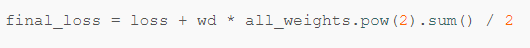

And formula for weight decay would be-

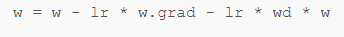

So a basic difference could be understood as that we add a penalizing term to the loss in the `L2-regularization` whereas we subtract an additional fraction of the weight from itself when updating it. Here `wd` is simply a hyperparameter which measures how larger decay in the weight you want at each update. 

That's why we added a `weight_decay` parameter here (from above code)-
    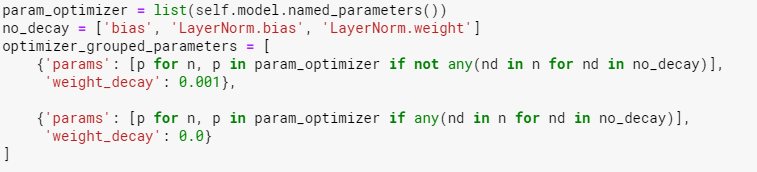
    
Here we are simply specifying a `weight_decay` value of 0 for the parameter for which we don't want the weights to decay additionally. Finally we pass this configuration to `AdamW` optimizer. With this we just combined the power of `Adam` optimization with weight_decay so that weights are learned and updated much more efficiently.

**Read more about AdamW from [here](https://www.fast.ai/2018/07/02/adam-weight-decay/).**

<p style="color: #1bab4e"><b>Till now I find that only AdamW optimizer should be explained and the rest of the code is easily understandable. However you could ask for any explanations in the comments or reach me out through mail and if I would be knowing that, I would be delighted to help you. Thanks!</b></p>

<p style="color:red;font-size:18px"><b>Hope You Guys Liked my notebook.</b></p>
<p style="color:magenta;font-size:18px"><b>Please upvote if you did to keep me motivated.😁😀</b></p>